### Import Modules

In [2]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout

# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


### Load lines from CSV file and split Train/Test

In [3]:
# # Are you using AWS?
# # Are you using Ricky's driving data?
# aws = False
# ricky = False

# if aws:
#     csv_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
#                 '/carnd-behavioral-cloning-p3/data/driving_log.csv'
#     image_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
#                 '/carnd-behavioral-cloning-p3/data/IMG/'
# else:
#     if ricky:
#         csv_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\driving_log.csv"
#         image_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\IMG\\"
#     else:
#         csv_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\driving_log.csv"
#         image_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\IMG\\"

# lines = []
# with tqdm(open(csv_path)) as csvfile:
#     reader = csv.reader(csvfile)
#     next(reader, None);
#     for line in reader:
#         lines.append(line)
        
# # Check if our CSV list is empty
# assert len(lines) > 0
# assert len(lines[0]) == 7

# train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [4]:
#%load data-consolidation.py
'''
THE GOAL

1.) Take a peak at the folders that containt the driving data
2.) Consolidate all the CSV files into a single list
3.) We will NOT augment or trim down any of th data in this script

Format of list
[
    [part1, part2, ..., part7]
    <many rows here>
    [part1, part2, ..., part7]
]

'''

from os import walk, path
from time import time
from csv import reader


def consolidate(path_to_folders, print_verbose=True):

    path_to_files = []
    lines = []

    if print_verbose:
        for a, b, c in walk(path_to_folders):
            print('root-------')
            print(a, '\n')
            print('\tdirs-------')
            for dir in b:
                # Skip the IMG folders
                if 'IMG' in dir: continue
                # Create a complete path to each folder
                print('\t\t', dir)
            print('\t\t\tfiles-------')
            print('\t\t\tfile count = {}'.format(len(c)))
            [print('\t\t\t\t', (file)) for file in c if 'csv' in file]
            file = [file for file in c if 'csv' in file]

    # Create list of full csv file paths
    for a, b, c in walk(path_to_folders):
        for file in c:
            if 'csv' in file:
                path_to_files.append(path.join(a, file))

    # Append lines of every CSV file to the list lines
    for file in path_to_files:
        folder_to_parse = file.split('\\')[-2]
        print('\nParsing \t\t==> {}'.format(folder_to_parse))

        start_time = time()
        with open(file, 'r', encoding='UTF-8') as csvfile:
            csv_reader = reader(csvfile)
            next(csv_reader, None)  # skip header
            for line in csv_reader:

                # rename the folder path since we have multiple folders (clockwise, corrections, etc.)
                # so line[0] will be like this 'clockwise\\center.png'
                orig = line[0]
#                 print('orig\n', orig)
                new = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + orig.split('\\')[-1]
#                 print('folder_to_parse\n', folder_to_parse)
#                 print('new line[0]\n', new)
                line[0] = new
#                 print('line\n', line)
                lines.append(line)
#                 break
#         print('\'lines\' length \t\t==>', len(lines))

        time_in_ms = (time()-start_time)*1000
        print('Done! Elapsed time(ms) \t==> {0:5.2f}'.format(time_in_ms))

    return lines

# if __name__ == '__main__':
#     lines = consolidate(r'D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky')
#     print(len(lines))


'\nTHE GOAL\n\n1.) Take a peak at the folders that containt the driving data\n2.) Consolidate all the CSV files into a single list\n3.) We will NOT augment or trim down any of th data in this script\n\nFormat of list\n[\n    [part1, part2, ..., part7]\n    <many rows here>\n    [part1, part2, ..., part7]\n]\n\n'

In [5]:
image_path = r'D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky'
lines = consolidate(image_path, print_verbose=False)
print('==> len(lines)', len(lines))
assert len(lines) > 0, "You've got no lines"
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
lines[0];


Parsing 		==> clockwise
Done! Elapsed time(ms) 	==>  5.00

Parsing 		==> counter-clockwise
Done! Elapsed time(ms) 	==>  4.00

Parsing 		==> turn-corrections
Done! Elapsed time(ms) 	==>  1.00
==> len(lines) 2227


### Create Generator Function

In [6]:
def generator(samples, batch_size=16):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
#                 source_path = batch_sample[0]
#                 filename = '\\' + source_path.split('\\')[-2] + '\\IMG\\' + source_path.split('\\')[-1]
#                 image_path_list = image_path + filename
#                 print('source path\t{}\n' \
#                       'filename\t{}\n' \
#                       'image_path\t{}\n' \
#                       'image_path_list\t{}\n\n'.format(source_path, filename, image_path, image_path_list))
#                 print('batch_sample[0]', batch_sample[0])
                image = cv2.imread(batch_sample[0])
                assert image !=None, 'Looks like you may have the wrong IMG destination\n{batch}'.format(5)
#                 plt.imshow(image)
#                 plt.show()
                images.append(image)
                angle = float(batch_sample[3])
                angles.append(angle)
                
                # Flip images and steering angles
                if angle == 0.0: continue
                images.append(cv2.flip(image, 1))
                angles.append(angle*-1.0)
#                 break
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [7]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Plot Initial Distribution

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


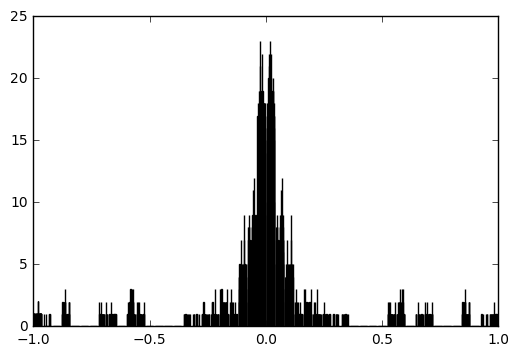

In [8]:
# print(train_geneartor)
# next(train_generator)
X, y = next(train_generator);
y_values = []
i = 0
for x,y in train_generator:
    i += 1
    y_values.append(y)
    if i == 62: break
y_values
# print(X.shape)
# print(y.shape)
plt.hist(y_values, 50)
plt.show()
# print(X)
len(validation_samples)
validation_samples[0];


### Parse CSV file

In [10]:
# images = []
# measurements = []
# for line in tqdm(lines):
#     source_path = line[0]
#     filename = source_path.split('/')[-1]
#     image_path_list = image_path + '/' + filename
#     image = cv2.imread(image_path_list)
#     images.append(image)
#     measurement = float(line[3])
#     measurements.append(measurement)

### Flip Image and Steering Angle

In [11]:
# augmented_images, augmented_measurements = [], []
# for image, measurement in zip(images, measurements):
#     augmented_images.append(image)
#     augmented_measurements.append(measurement)
#     # Avoid adding all angles that are at 0.0
#     if measurement == 0.0: continue
#     augmented_images.append(cv2.flip(image, 1))
#     augmented_measurements.append(measurement*-1.0)

### Construct Model

In [11]:
# batch_size = 32

# X_train = np.array(augmented_images)
# y_train = np.array(augmented_measurements)

# X_train = np.array(images)
# y_train = np.array(measurements)

# Model 1 - barebones model
# model = Sequential()
# model.add(Flatten(input_shape=(160,320,3)))
# model.add(Dense(128))
# model.add(Dense(84))
# model.add(Dense(1))

# Model 2
# model = Sequential()
# model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
# model.add(Convolution2D(32,3,3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(Convolution2D(16, 3, 3, border_mode='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(84))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))

# Model 3
model = Sequential()
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(64,3,3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Convolution2D(16, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

### Train, Validate, and Save Model

In [ ]:
model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, batch_size=batch_size)

nb_val_samples = len(validation_samples)
nb_epoch = 7

# Complie modile with Generator
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), \
                   validation_data=validation_generator, \
                   nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, \
                   verbose=1)

model.save('model-ricky-data.h5')
print('model {} saved'.format(model.__str__))

Epoch 1/7


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


1391/1781 [======================>.......] - ETA: 15s - loss: 0.0034

### Analyze how well the model does

In [13]:
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


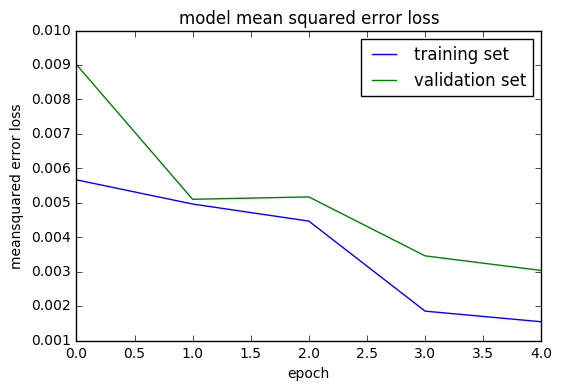

In [16]:
plt.plot(history_object.history['val_loss'])
plt.plot(history_object.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('meansquared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()